
# **Project 1 (1223239758): Gradient-based Algorithms and Differentiable Programming**
**1. Introduction** \\
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$
where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$
where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad ||x(T)||^2 \\
\quad        d(t+1) = d(t) + v(t) \Delta t, \\
\quad       v(t+1) = v(t) + a(t) \Delta t, \\
\quad       a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$
While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$.

In the following, we code this problem up with PyTorch, which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$

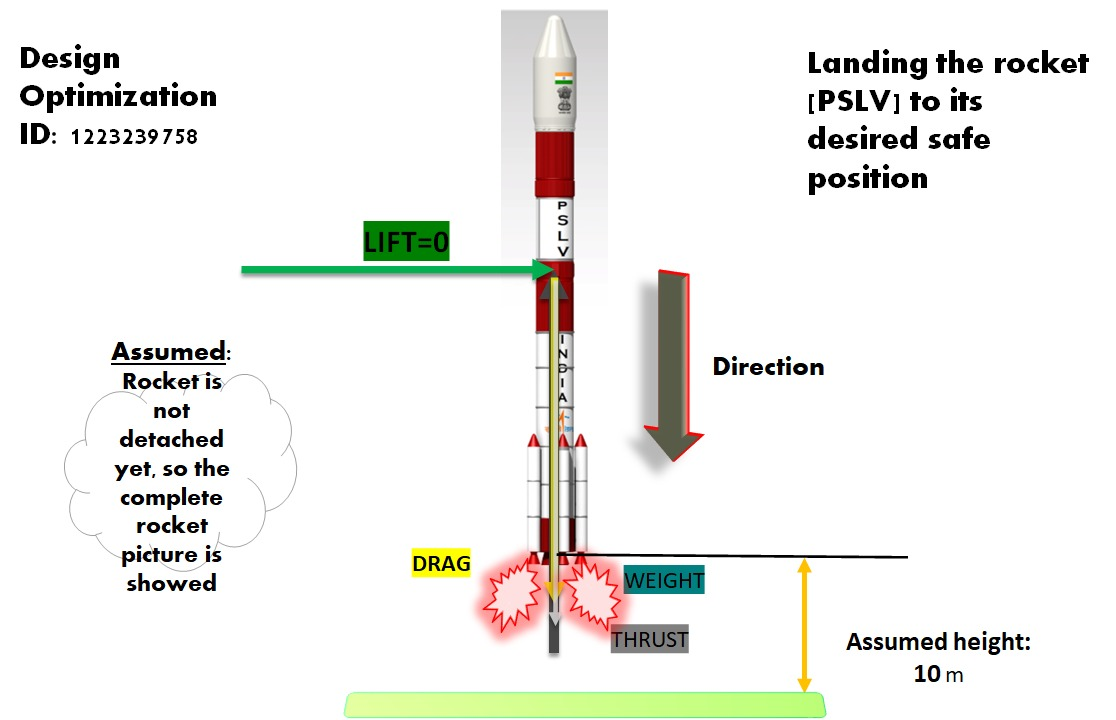

##**Description**: Here we have taken PSLV 3G (3rd generation) Rocket
The above figure is meant to indicate that the rocket is landing at an height of 10 meters to zero position and the given below calculations and parameters will make the rocket to land in its safest position without any crash

##**2-**Defining the **Objective function** 

$$
\begin{aligned}
\    min_{\theta}\quad ||x(T)||^2 \\
\\  where:x(T) = (y(T) ,& v_y(T)  \\
\end{aligned}
$$
##**3-Variables**  
x= X-Coordinate \\
y= Y-Coordinate \\
t= Time \\
Ft= Frame_Time \

##**Parameters**: 
Gravitational acceleration (g) and Total time (t)

##**4-Constraints**  
$$
\begin{aligned}
\ y(t+1)= y(t)+v_y(t)+ Δt \\
\ v_y(t+1)= v_y (t)+a_y(t)Δt- a d(t)Δt \\
\ a_y(t+1)= -g+ aR R_y(t)Δt+ ad(t)R_y(t) Δt \\
\end{aligned}
$$
##**5-Assumptions** involved in formulating the problem.
1-The rocket is not detached yet and it just launched and landing to its zero position \\
2-The height between the ground and rocket end is assumed as 10 meters \\



#Calculations:
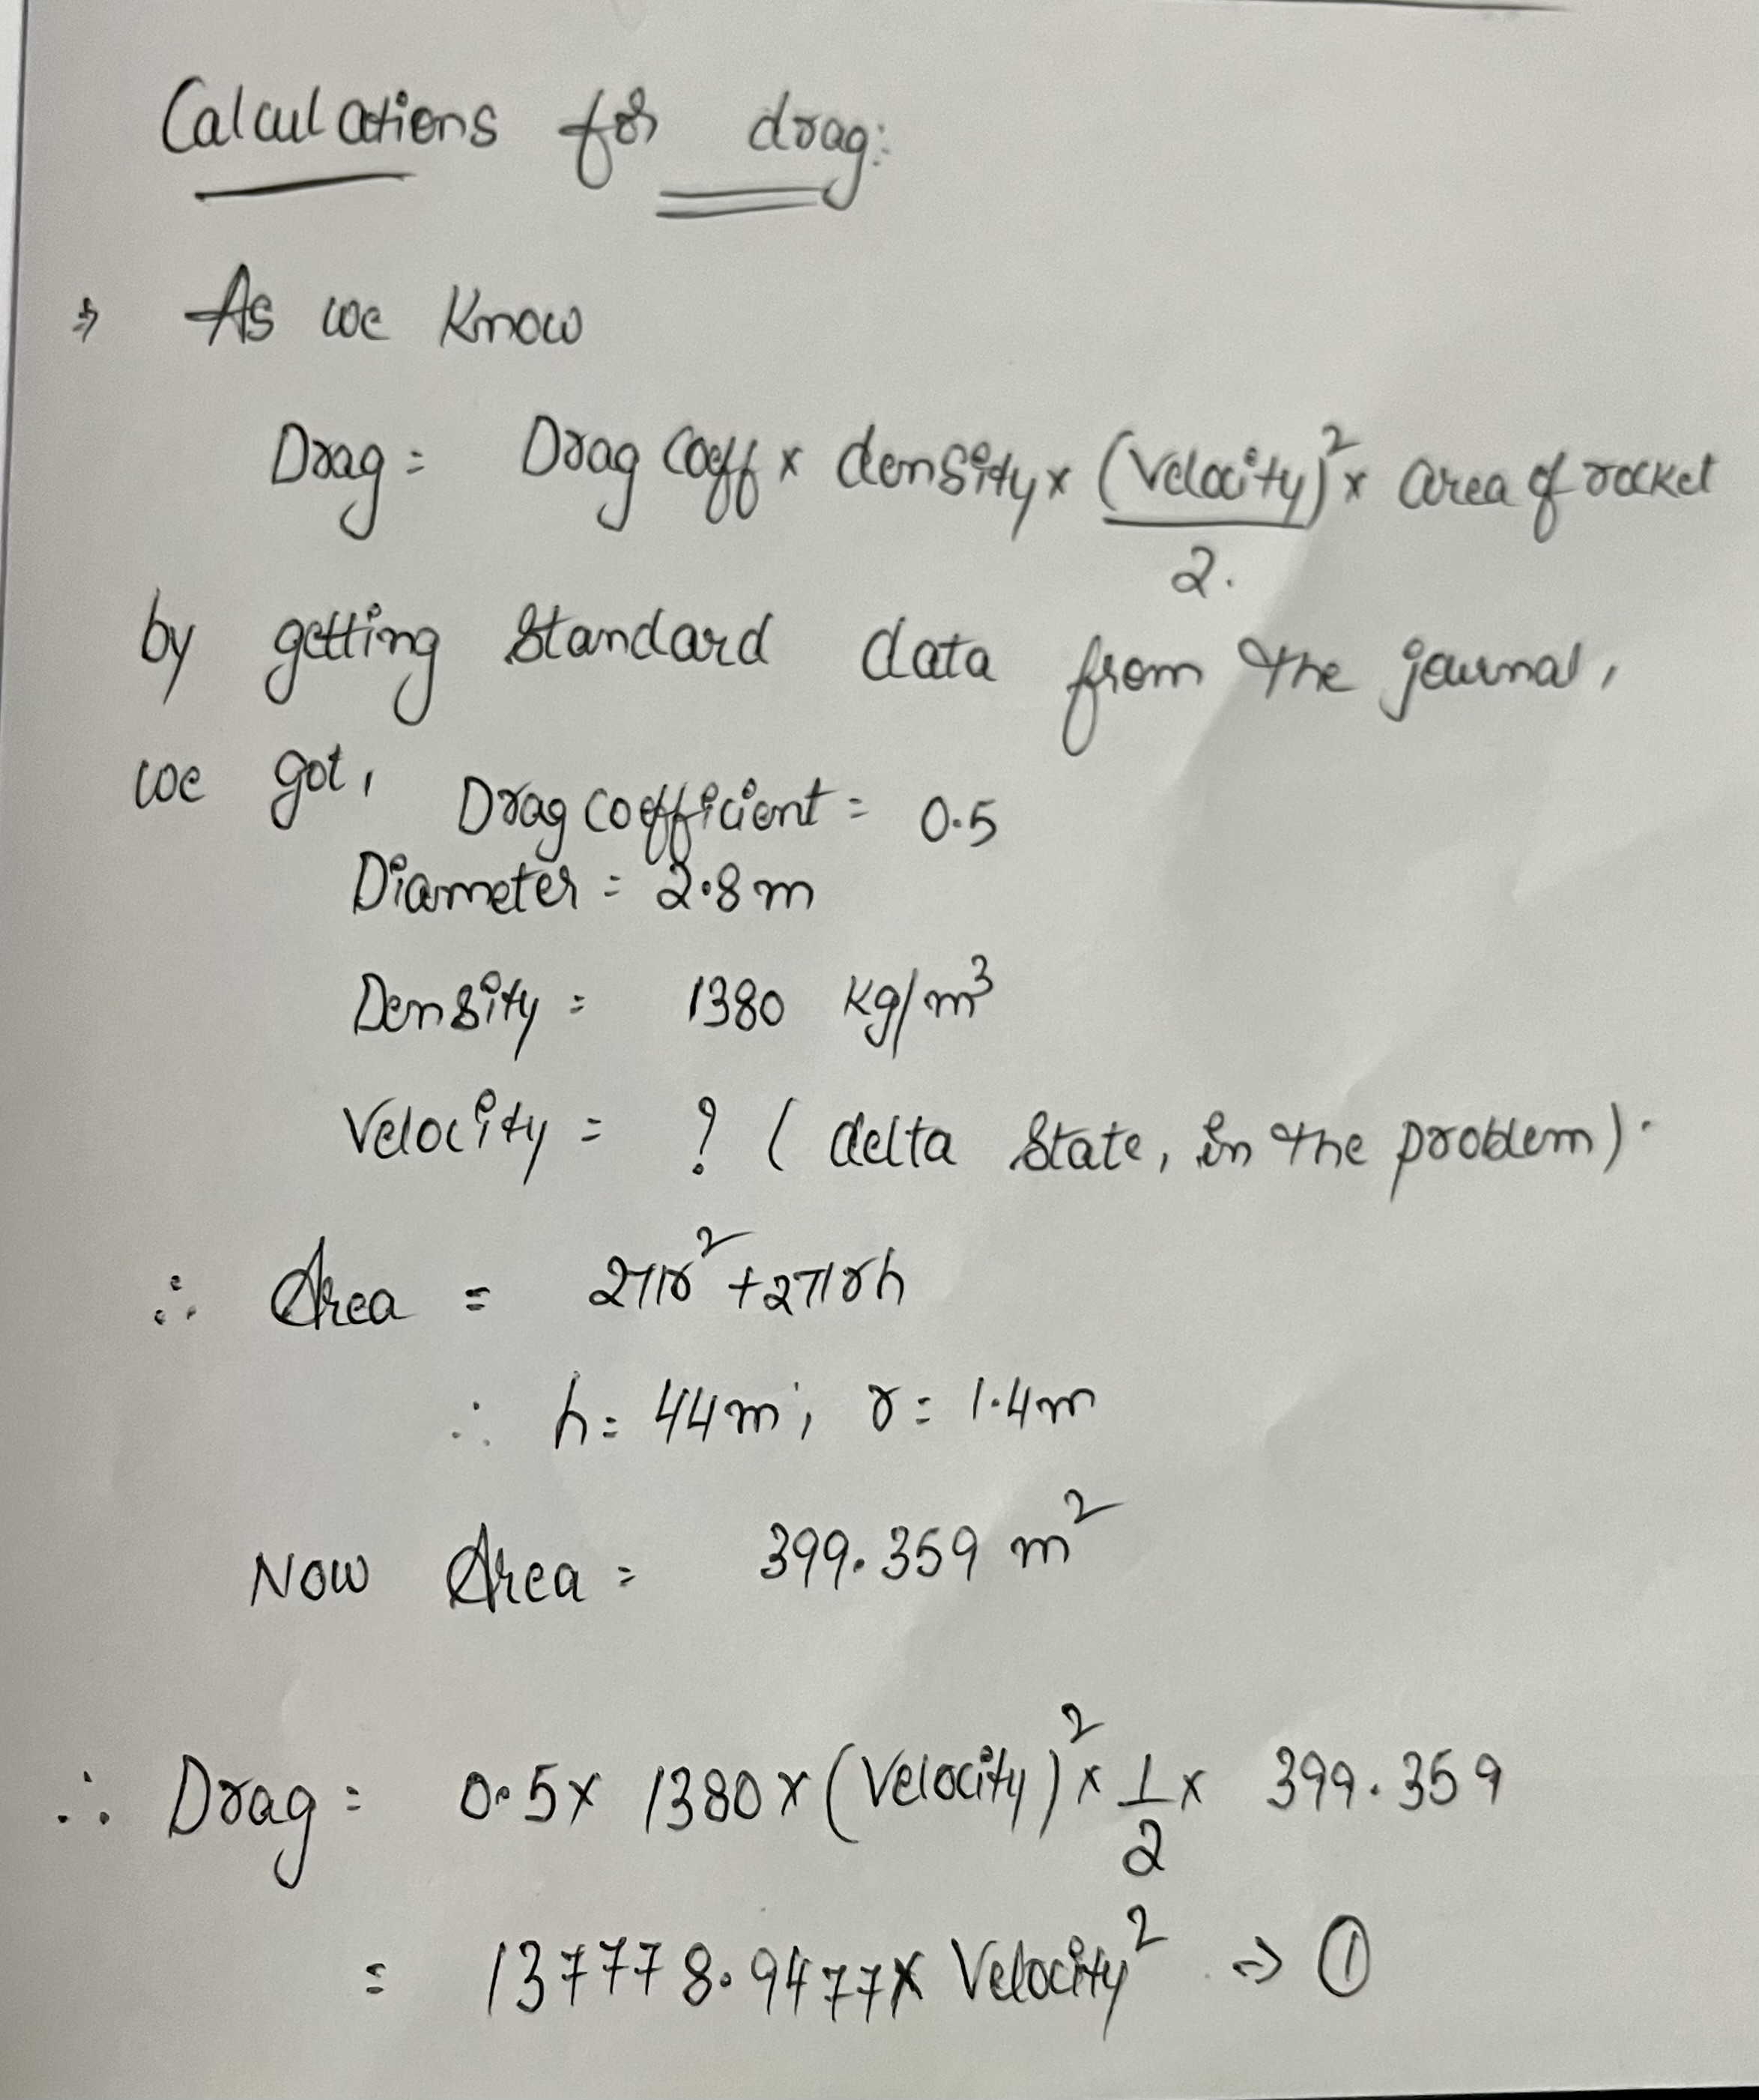


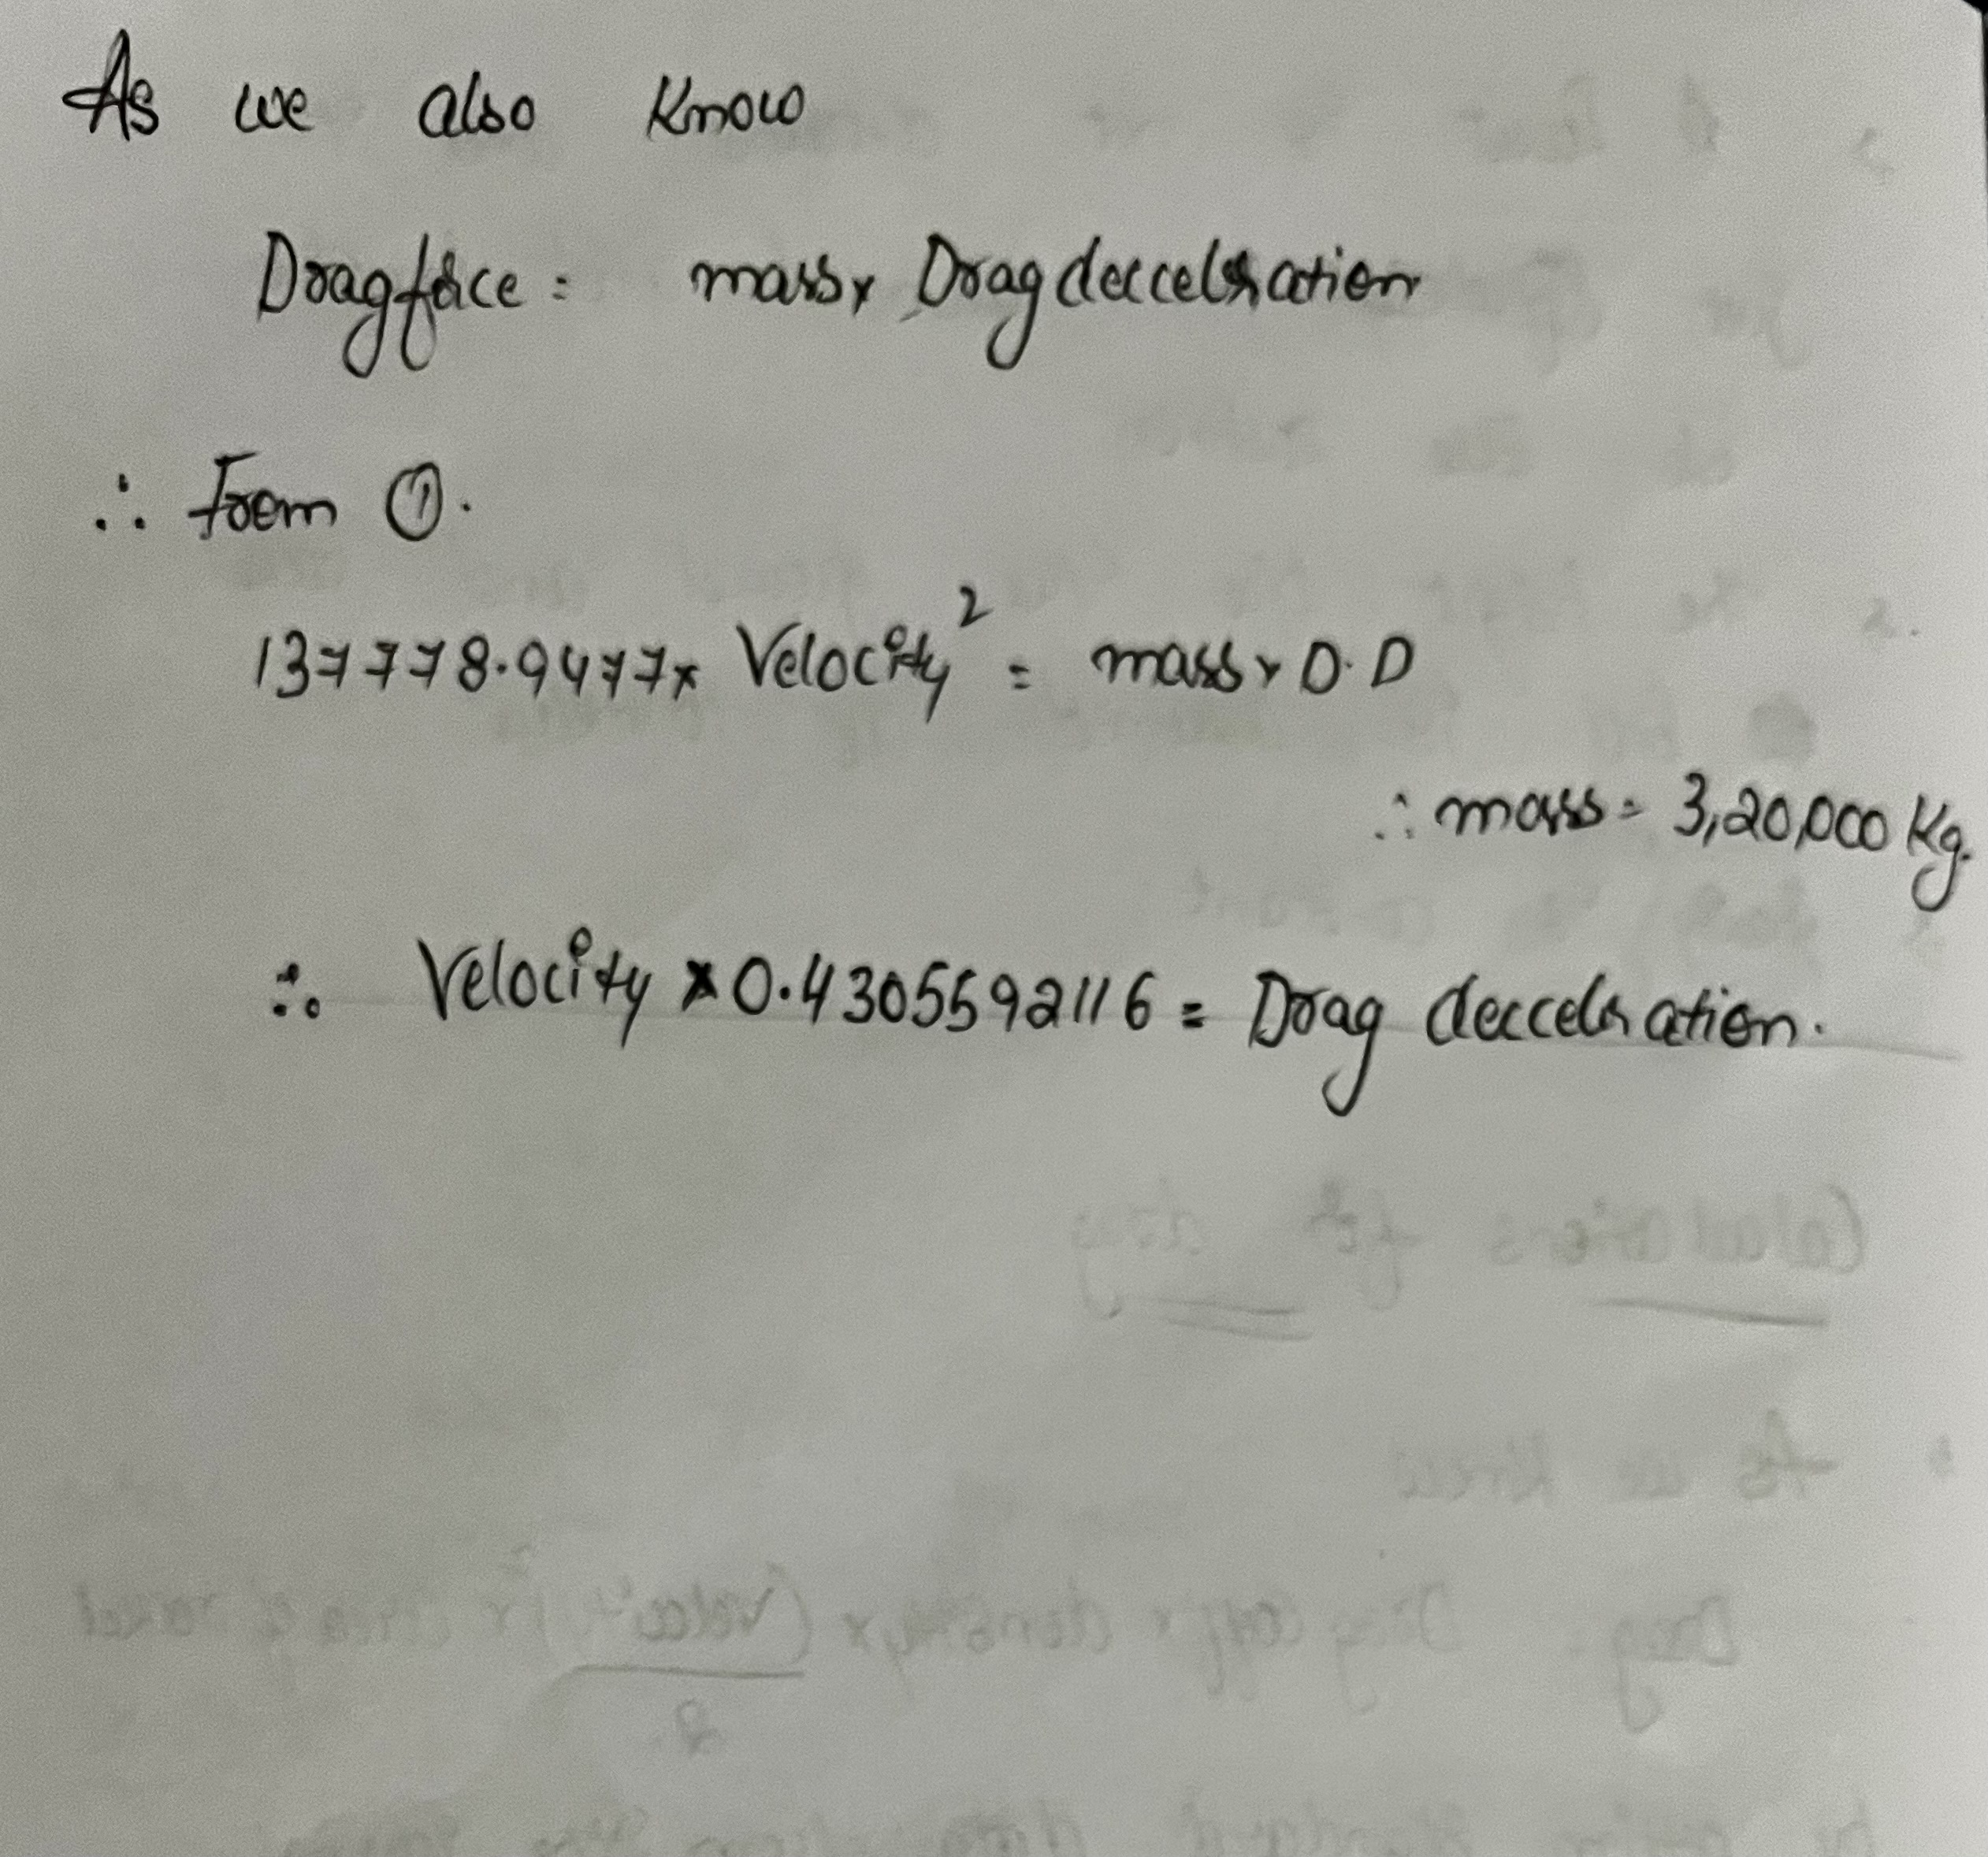

In [ ]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


logger = logging.getLogger(__name__)

In [ ]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 12  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [ ]:
# define system dynamics where the foces are defined here 
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust and DRAG is considerd 
        state[0] = y
        state[1] = y_dot
        """
       
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        
        velocity = delta_state
        #Calculations for the drag are attached above
        #Updating drag
        DRAG_DECEL = 0.4305592116*velocity**2
        
        OVERALL_ACCEL = BOOST_ACCEL - DRAG_DECEL
        
        #Re-calculating new velocity
        delta_state = OVERALL_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [ ]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [ ]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [10., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [ ]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        fig=plt.figure(figsize=(8,8))
        plt.axes(projection ='3d')
        x = data[:, 0]
        y = data[:, 1]     
        plt.title('Top view for better graphical understanding')
        plt.xlabel('X_Distance')
        plt.ylabel('X_Velocity')        
        plt.plot(x, y, color= 'indigo', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2,
         markersize=10, markevery=3)
        plt.show()                              

[1] loss: 30146.525


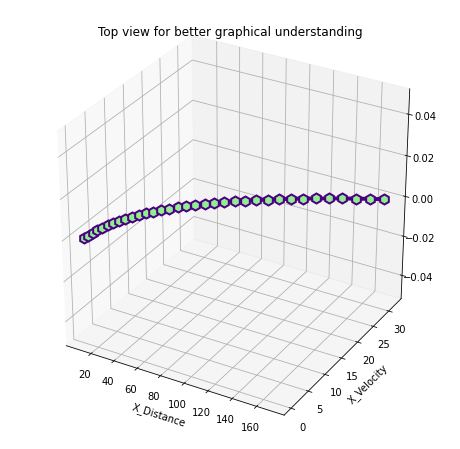

[2] loss: 21814.045


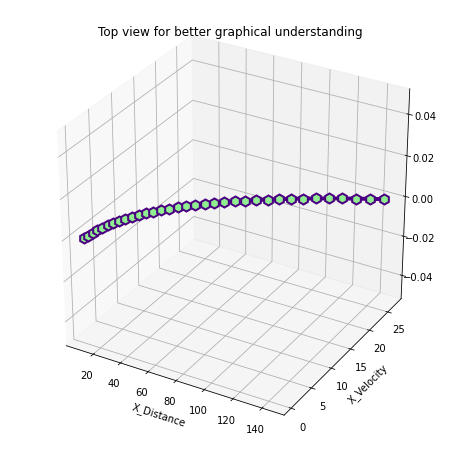

[3] loss: 16019.476


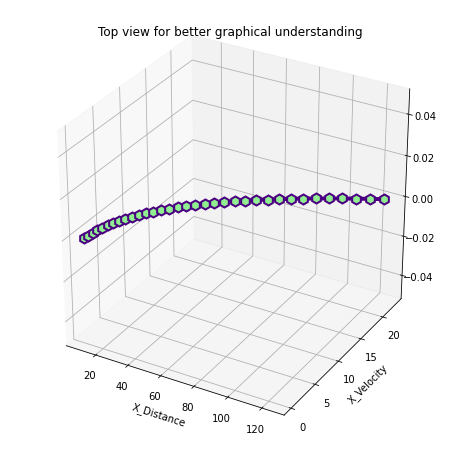

[4] loss: 11853.098


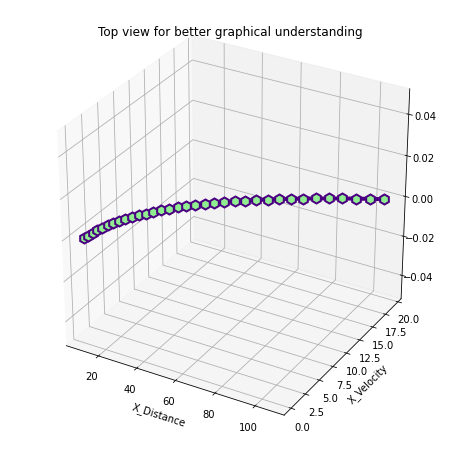

[5] loss: 8786.347


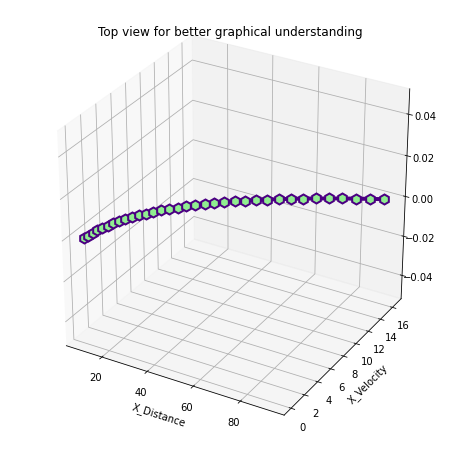

[6] loss: 6093.373


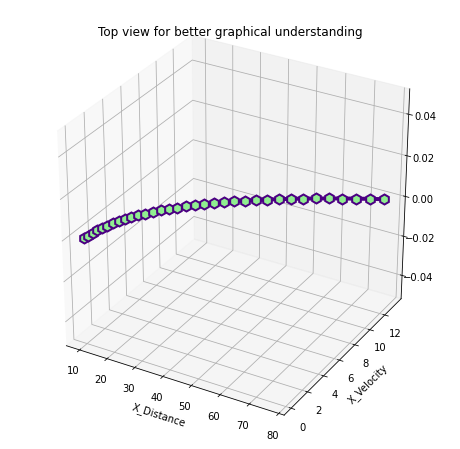

[7] loss: 614.981


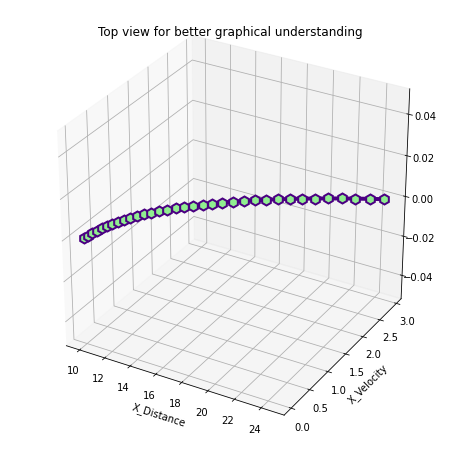

[8] loss: 415.799


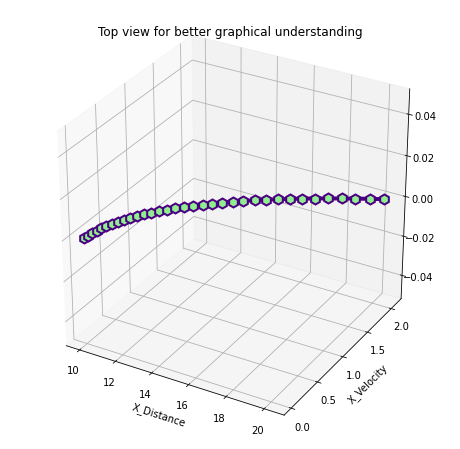

[9] loss: 271.192


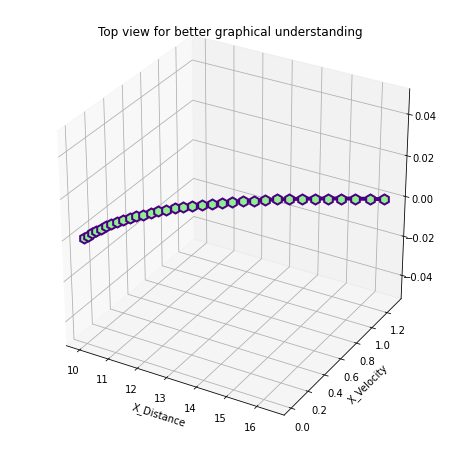

[10] loss: 174.105


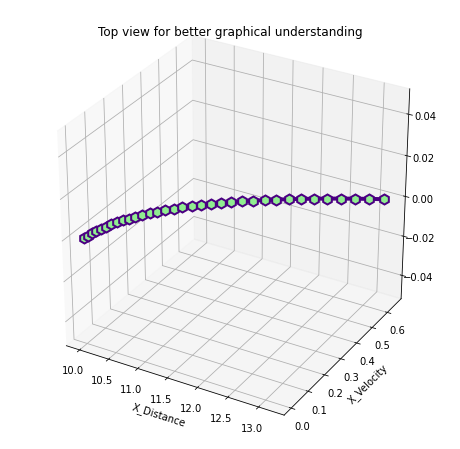

[11] loss: 112.748


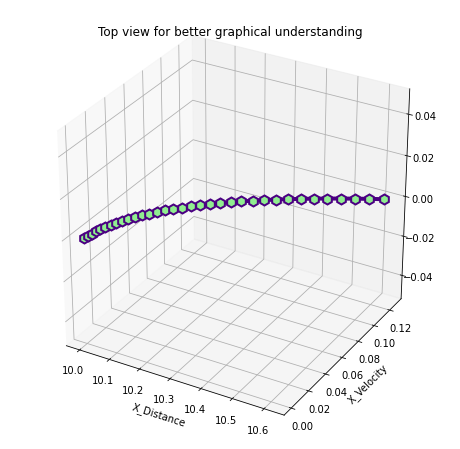

[12] loss: 74.844


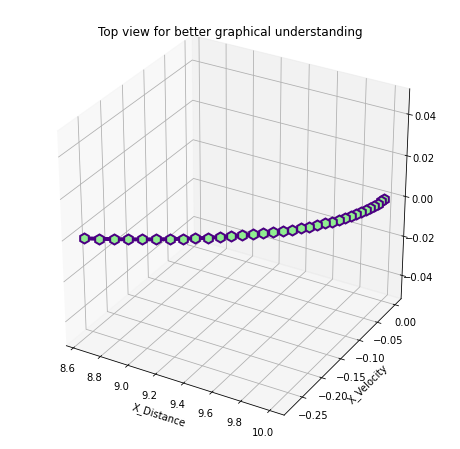

[13] loss: 51.010


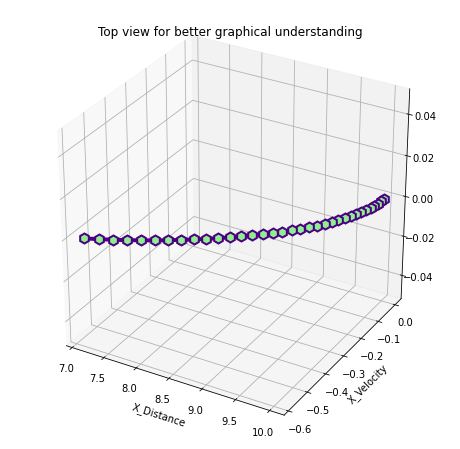

[14] loss: 35.620


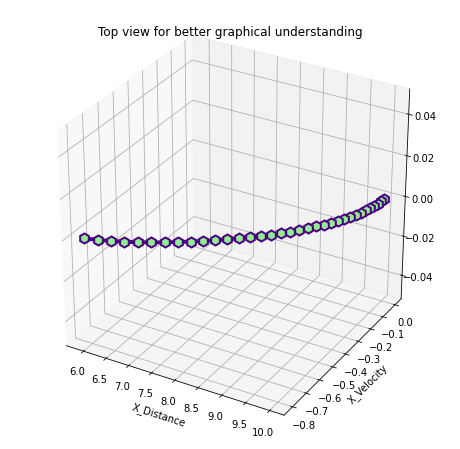

[15] loss: 25.493


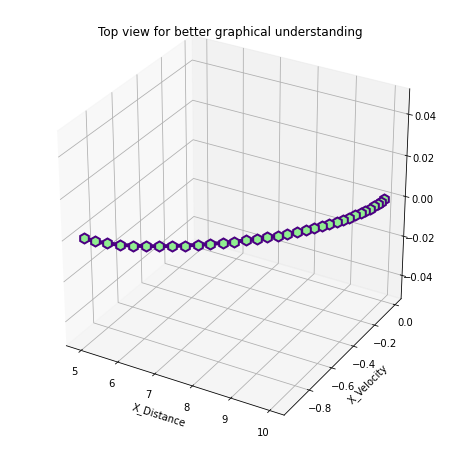

[16] loss: 18.725


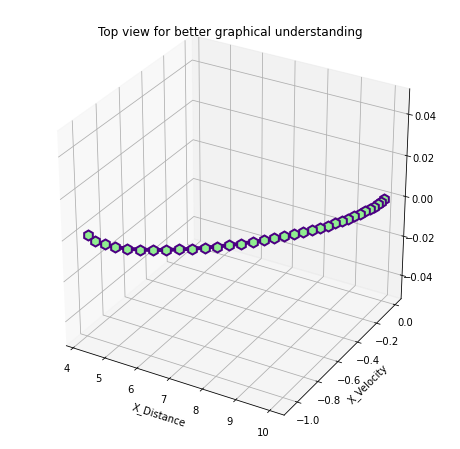

[17] loss: 14.116


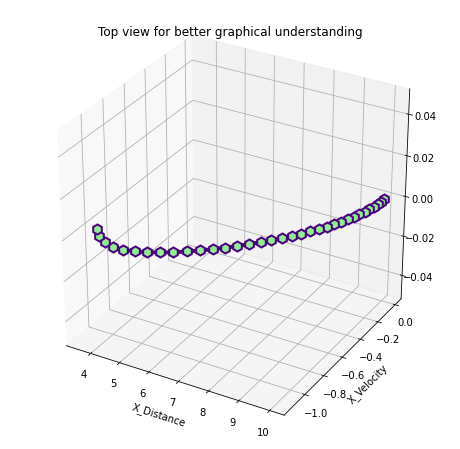

[18] loss: 10.921


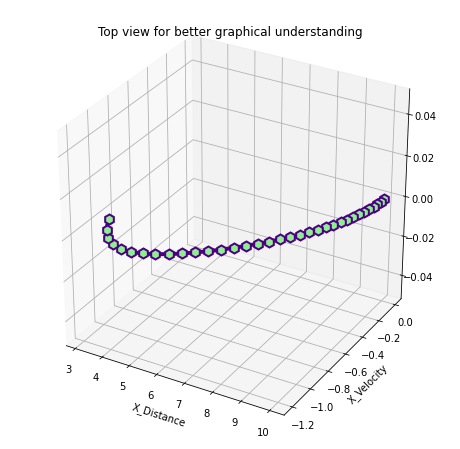

[19] loss: 8.646


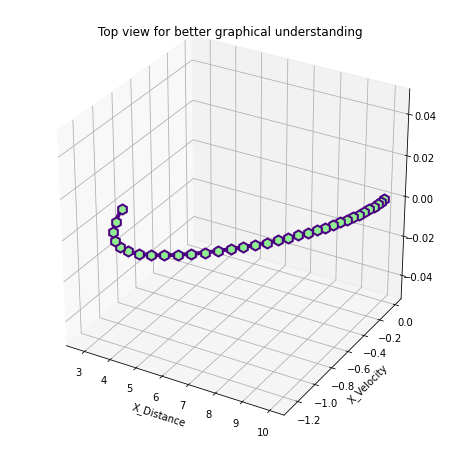

[20] loss: 6.964


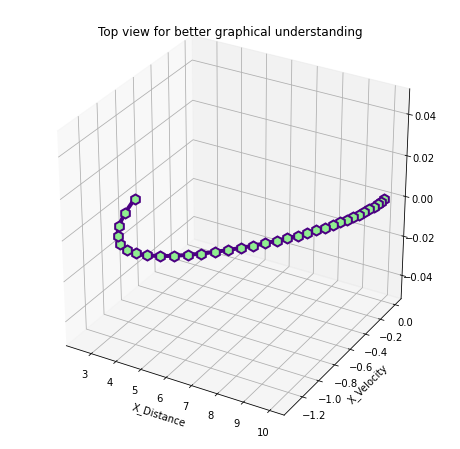

[21] loss: 5.668


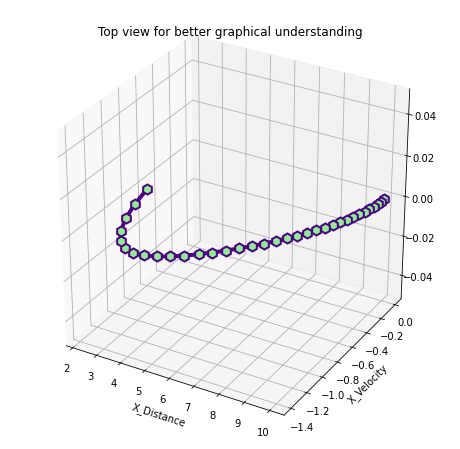

[22] loss: 4.637


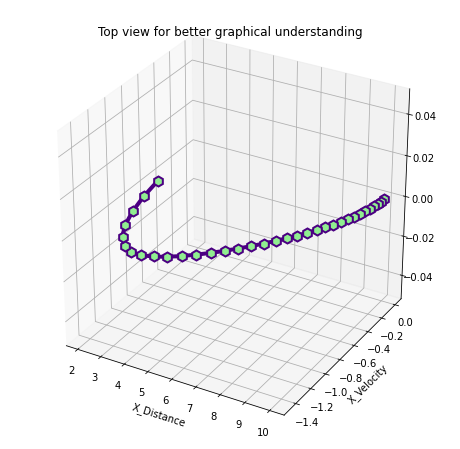

[23] loss: 3.796


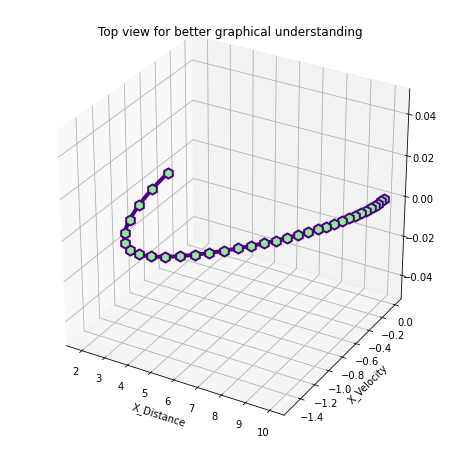

[24] loss: 3.088


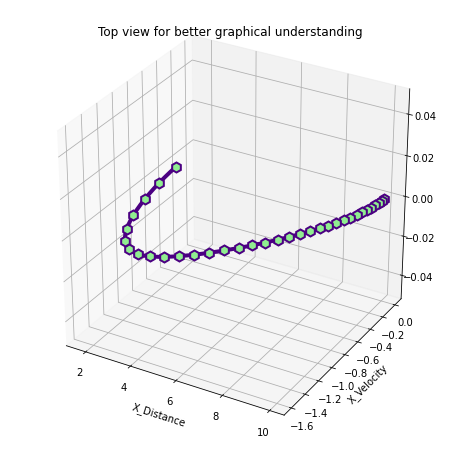

[25] loss: 2.458


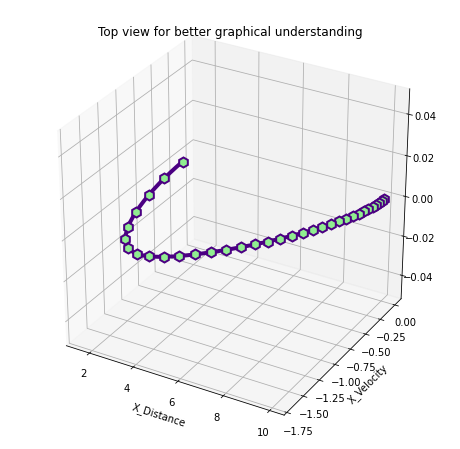

[26] loss: 1.870


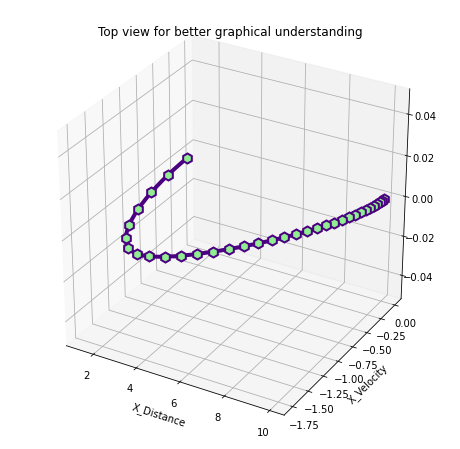

[27] loss: 1.327


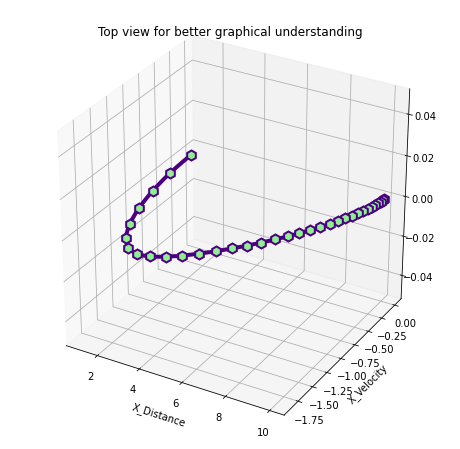

[28] loss: 0.872


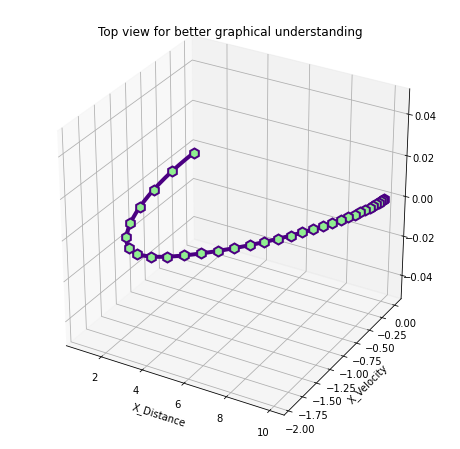

[29] loss: 0.536


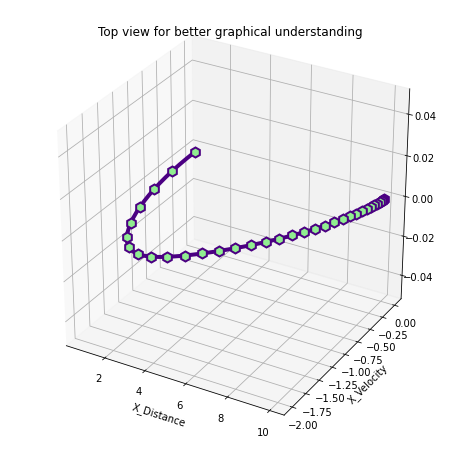

[30] loss: 0.314


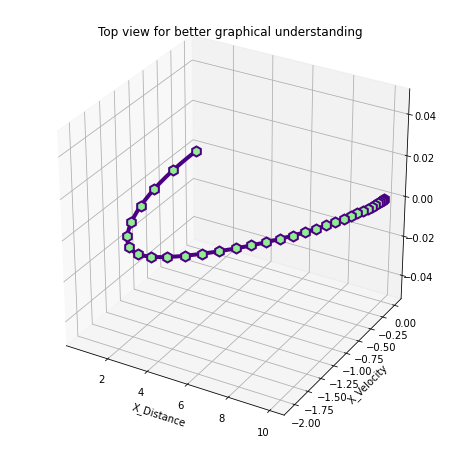

[31] loss: 0.184


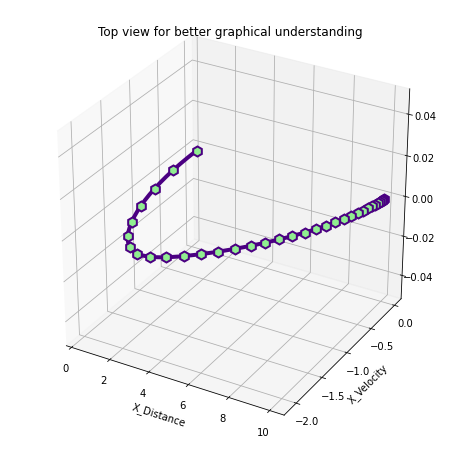

[32] loss: 0.110


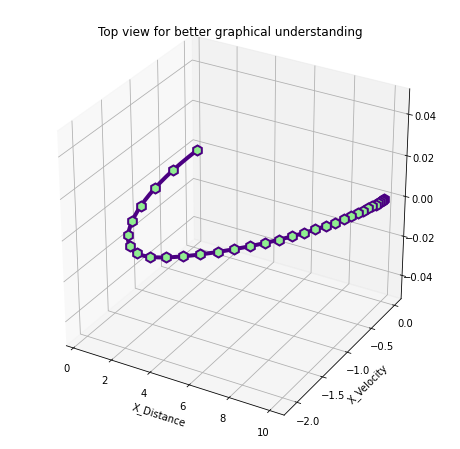

[33] loss: 0.067


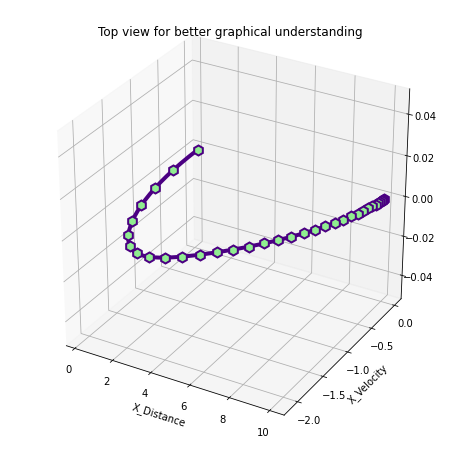

[34] loss: 0.042


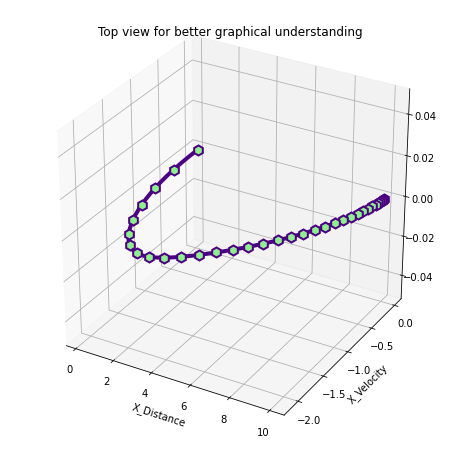

[35] loss: 0.027


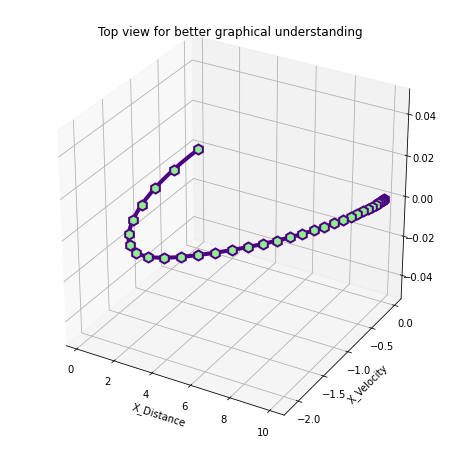

[36] loss: 0.017


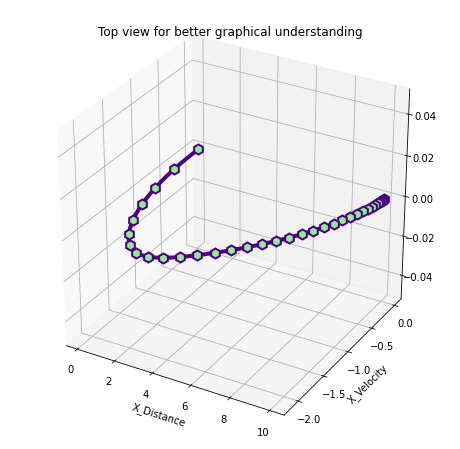

[37] loss: 0.011


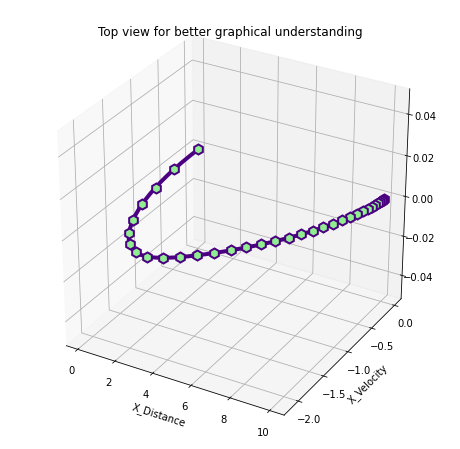

[38] loss: 0.007


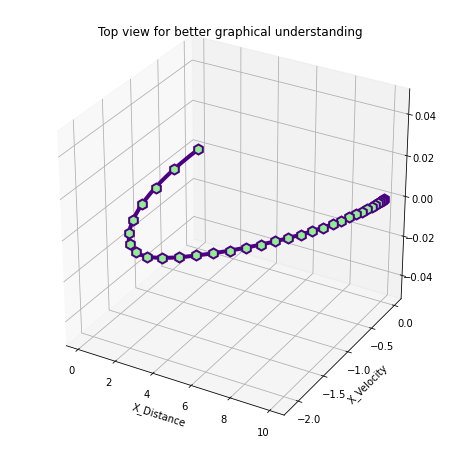

[39] loss: 0.005


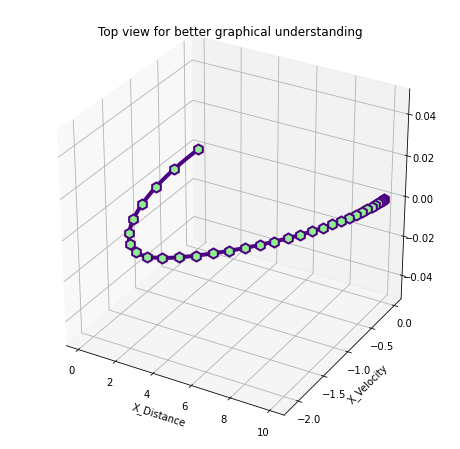

[40] loss: 0.003


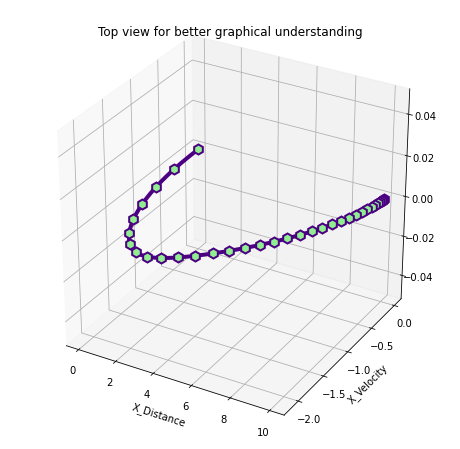

[41] loss: 0.002


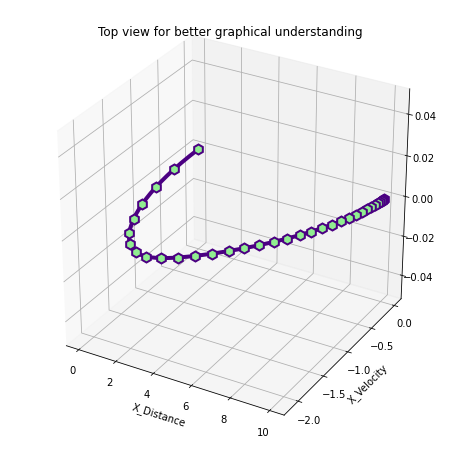

[42] loss: 0.001


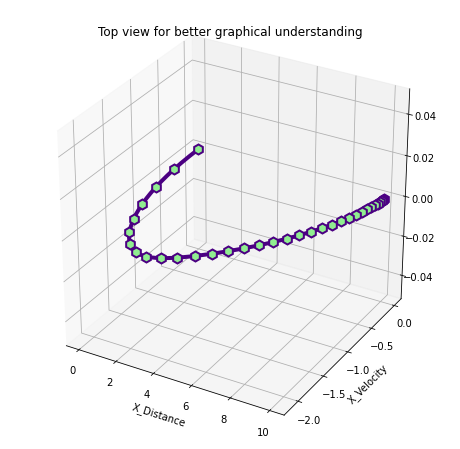

[43] loss: 0.001


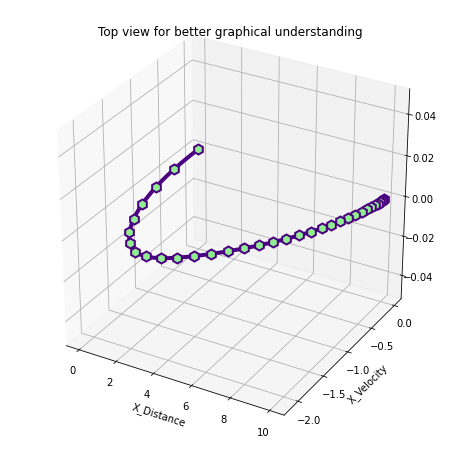

[44] loss: 0.001


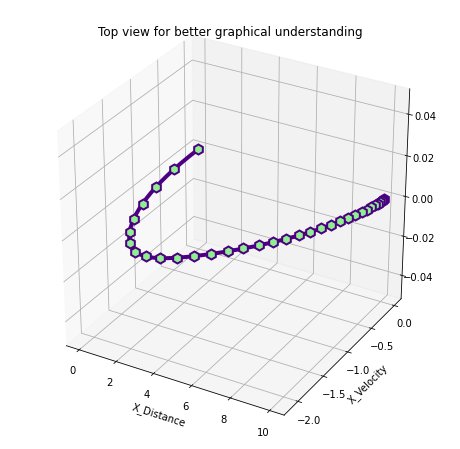

[45] loss: 0.000


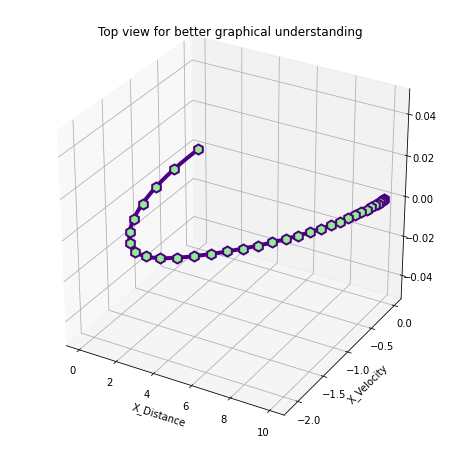

[46] loss: 0.000


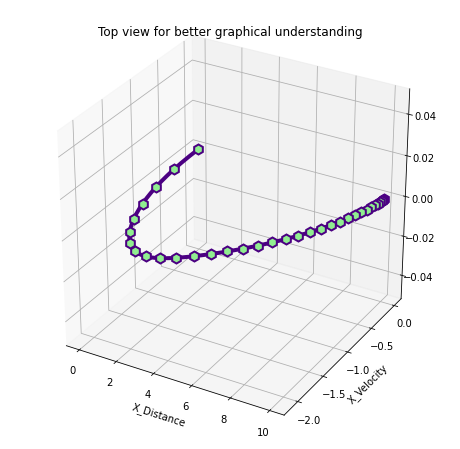

[47] loss: 0.000


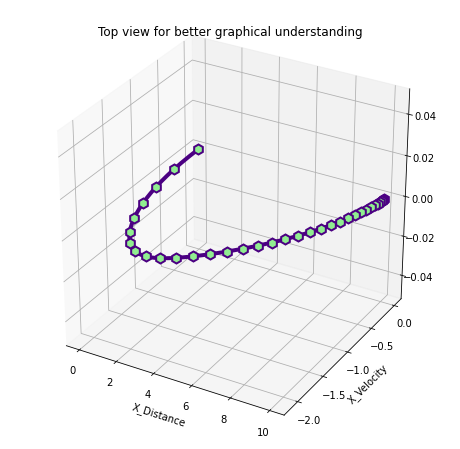

[48] loss: 0.000


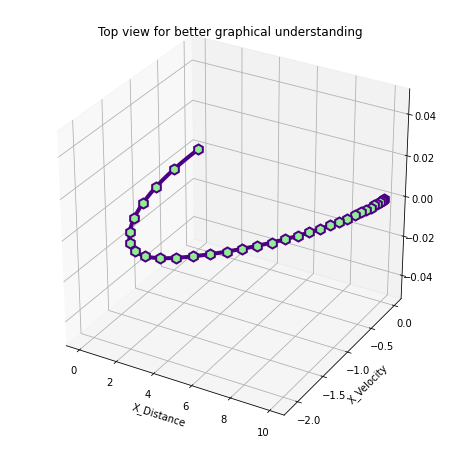

[49] loss: 0.000


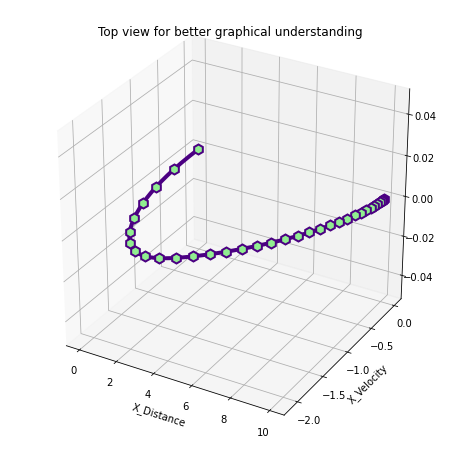

[50] loss: 0.000


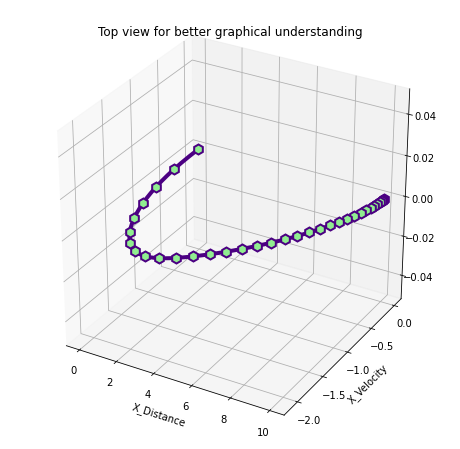

In [ ]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2 # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem

##**6-Analysis and Conclusion**:
1-The project is done by landing the rocket in its safest position with taking the minimization function and optimizing it \\
2-Number of itterations followed= 50 and making the loss value as 0.000 \\
3-The rocket is subjected to 4 forces weight, thrust and aerodynamic forces (lift and drag). We have taken the PSLV rocket data for drag calculations 
4- Although the loss value is 0.872 at 28th itteration by optimizing in a better way and obtating the loss to  0.000 with zero velocuty at 50th itteration shows the effect data in the graph \\
5- The graph indicates the distance covered by the rocket and the velocity as (0,0) \\
6- By making distance and velocity  zero, made the rocket to land in steady state without any crash  